# Entraînement et Optimisation de XGBoost\n\nCe notebook implémente l'entraînement d'un modèle XGBoost avec une approche de base et une approche optimisée (Optuna + TimeSeriesSplit).\n\nObjectifs :\n1. Préparer les données (gestion des catégories).\n2. Entraîner un modèle de base avec les paramètres suggérés.\n3. Optimiser les hyperparamètres via Optuna et Validation Croisée Temporelle.\n4. Évaluer et sauvegarder le meilleur modèle.\n

In [1]:
import sys
# Force installation if needed
!{sys.executable} -m pip install optuna xgboost --break-system-packages

import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import os
import pickle
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.INFO)

os.makedirs('trained_models', exist_ok=True)

Defaulting to user installation because normal site-packages is not writeable


/home/raph/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Chargement des Données

In [2]:
train_X_path = 'donnees_pretraitees/X_train_7_jours.csv'
train_y_path = 'donnees_pretraitees/y_train_7_jours.csv'
test_X_path = 'donnees_pretraitees/X_test_7_jours.csv'
test_y_path = 'donnees_pretraitees/y_test_7_jours.csv'

X_train = pd.read_csv(train_X_path)
y_train = pd.read_csv(train_y_path)
X_test = pd.read_csv(test_X_path)
y_test = pd.read_csv(test_y_path)

if y_train.shape[1] == 1: y_train = y_train.iloc[:, 0]
if y_test.shape[1] == 1: y_test = y_test.iloc[:, 0]

# Conversion Category pour XGBoost (enable_categorical=True)
cat_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']
for col in cat_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (56000, 65), Test: (14100, 65)


## 2. Modèle de Base
Entraînement avec les paramètres fournis par l'utilisateur.

In [3]:
base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 8,
    'min_child_weight': 5,
    'gamma': 0.1,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'enable_categorical': True
}

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

print("Training Base Model...")
base_model = xgb.train(
    base_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

preds_base = base_model.predict(dtest)
rmse_base = np.sqrt(mean_squared_error(y_test, preds_base))
print(f"Base Model RMSE: {rmse_base:.4f}")

Training Base Model...
[0]	Test-rmse:108.98909
[53]	Test-rmse:109.25690
Base Model RMSE: 109.2667


## 3. Optimisation Optuna avec TimeSeriesSplit

In [4]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'enable_categorical': True,
        'n_jobs': -1,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        d_tr = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
        d_val = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
        
        model = xgb.train(
            params,
            d_tr,
            num_boost_round=500,
            evals=[(d_val, 'Val')],
            early_stopping_rounds=20,
            verbose_eval=False
        )
        
        p_val = model.predict(d_val)
        rmse = np.sqrt(mean_squared_error(y_val, p_val))
        scores.append(rmse)
        
    return np.mean(scores)

print("Optimization starts...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best Params:", study.best_params)

[I 2026-01-05 18:04:08,298] A new study created in memory with name: no-name-04eb3a34-f6bc-4302-a3e6-0cbe1566e97c


Optimization starts...


[I 2026-01-05 18:04:09,306] Trial 0 finished with value: 110.83097927625334 and parameters: {'max_depth': 9, 'learning_rate': 0.12140820449841333, 'subsample': 0.5568848867328362, 'colsample_bytree': 0.7487380417643833, 'min_child_weight': 3, 'gamma': 3.9755262950035375, 'reg_alpha': 1.2877278360831408e-05, 'reg_lambda': 0.09739473663250751}. Best is trial 0 with value: 110.83097927625334.
[I 2026-01-05 18:04:09,723] Trial 1 finished with value: 109.35742396360281 and parameters: {'max_depth': 4, 'learning_rate': 0.15283261794431524, 'subsample': 0.7945217041897932, 'colsample_bytree': 0.7585074362421649, 'min_child_weight': 2, 'gamma': 0.05984310312375174, 'reg_alpha': 1.7266243558700845e-07, 'reg_lambda': 4.522982703491121}. Best is trial 1 with value: 109.35742396360281.
[I 2026-01-05 18:04:11,288] Trial 2 finished with value: 113.95178326485807 and parameters: {'max_depth': 11, 'learning_rate': 0.24421560590876648, 'subsample': 0.9668099172256379, 'colsample_bytree': 0.747002650973

Best Params: {'max_depth': 3, 'learning_rate': 0.013930877267006666, 'subsample': 0.940493704157886, 'colsample_bytree': 0.6526845209927739, 'min_child_weight': 2, 'gamma': 0.7978425188968341, 'reg_alpha': 0.17506790803564837, 'reg_lambda': 0.030918691019533637}


## 4. Entraînement Final et Évaluation

Training Final Model...
[0]	Test-rmse:108.98797
[64]	Test-rmse:108.99077

Final Optimized RMSE: 108.9898
Final Optimized MAE: 89.3376


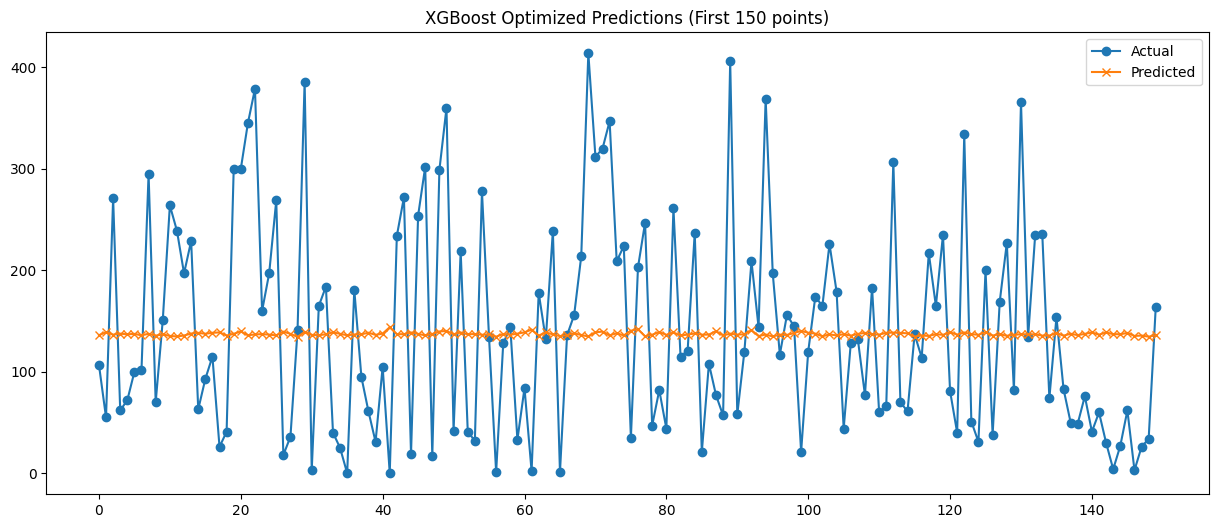

In [5]:
final_params = study.best_params
final_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'enable_categorical': True,
    'random_state': 42,
    'n_jobs': -1
})

print("Training Final Model...")
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=1500,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Predictions
preds = final_model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print(f"\nFinal Optimized RMSE: {rmse:.4f}")
print(f"Final Optimized MAE: {mae:.4f}")

# Save
with open('trained_models/xgboost_model_optimized.pkl', 'wb') as f:
    pickle.dump(final_model, f)
    
with open('trained_models/xgboost_metrics_optimized.txt', 'w') as f:
    f.write(f"RMSE: {rmse}\nMAE: {mae}\nBest Params: {final_params}")

# Viz
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:150], label='Actual', marker='o')
plt.plot(preds[:150], label='Predicted', marker='x')
plt.title("XGBoost Optimized Predictions (First 150 points)")
plt.legend()
plt.show()